# SyNBEARTS Example Usage

This is a Jupyter notebook that gives some examples of using the `SyNBEATS` package. It uses annual state-level panel data of cigarette sales for the period 1970 - 2000 and aims to estimate the effect of Proposition 99 on cigarette sales in California. Specifically, it trains a model to predict cigarette sales per capita in California during years prior to 1989, and apply the model out-of-sample to predict California cigarette sales per capita in 1989 onward.

First you need to install the dependencies

In [ ]:
%pip install -r requirements.txt

Then import the library and read the data into a Pandas DataFrame with columns names being `["id", "time", "Y_obs"]`

In [1]:
from SyNBEATS import *  # import the package
import pandas as pd
from tqdm.auto import tqdm

# read data and preprocess the column names into ["id", "time", "Y_obs"]
dta = pd.read_csv("smoking_data.csv")
dta = dta[["state", "year", "cigsale"]]
dta.columns = ["id", "time", "Y_obs"]

# create a SyNBEATS model. 3 is the index of California, and 1989 is the target time.
# The model will be trained with data for California before 1989 and will predict 
model = SyNBEATS(dta, [3], 1989, date_format='%Y')

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/home/siboma2/anaconda3/envs/synbeats/lib/python3.11/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Next we can train the model by calling `model.train()`. There are several parameters you can set to control the training process, and you can also set if you want to use CPU or GPU to train. You can find detailed explanation of the parameters in `README.md` in the [Github repo](https://github.com/Crabtain959/SyNBEATS). Here we train the model with default parameters and 1 GPU. 

In [2]:
model.train(use_gpu=1)


  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.278    Total estimated model params size (MB)


Epoch 1061: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s, train_loss=0.091] 


After training the model, the SyNBEATS object (the `model` variable) now has the predictions. You can use `model.predictions()` to get the predictions in Darts TimeSeries, or you can use `model.predictions(df=True)` to get them in Pandas DataFrame. You can also plot the predictions and the gap with the following commands:

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


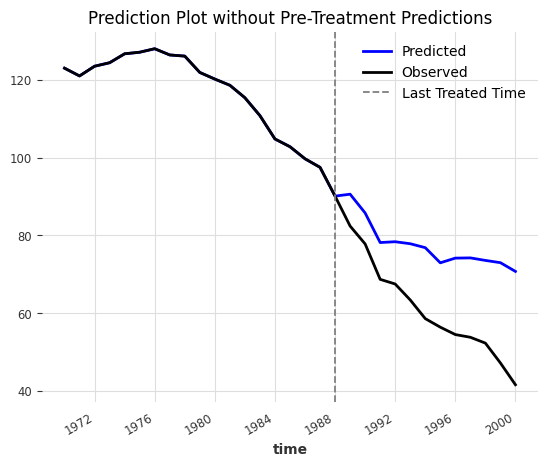

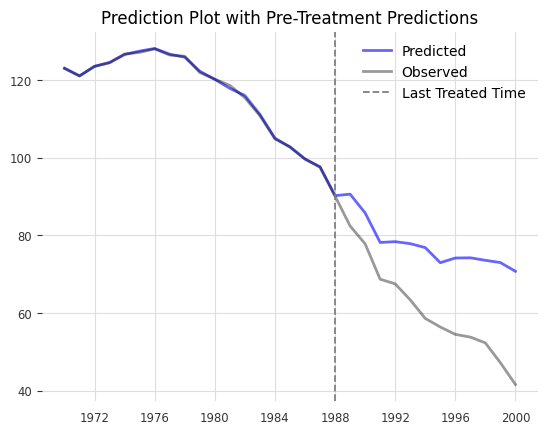

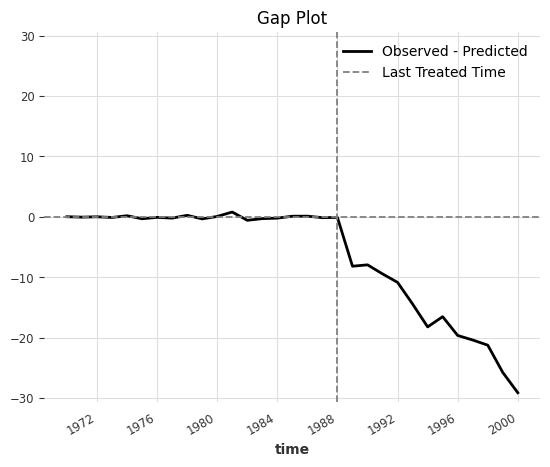

In [3]:
predictions = model.predictions()
model.plot_predictions(predictions)
model.plot_predictions(predictions, predict_pretreatment=True)
model.plot_gap()

You can also easily calculate the average treatment effect (ATE) and the standard deviation of the treatment effects

In [4]:
ate = model.average_treatment_effect()
std = model.std_treatment_effect()
ate, std

(-6.556073262270694, 9.144366780797478)

### Placebo Test

We also include a placebo text function that helps you perform a placebo test with one function call. Like the function `train`, you can also set a set of parameters to control the process, as well as the placebo units you would like to use. Here we use states with index from 4 to 14 as placebo units and run it with 1 GPU. The function will return the predictions for each placebo unit and a p-value

Starting the placebo test...


Processing placebo for control id 13: 100%|██████████| 10/10 [09:09<00:00, 54.94s/it]


Placebo test completed.


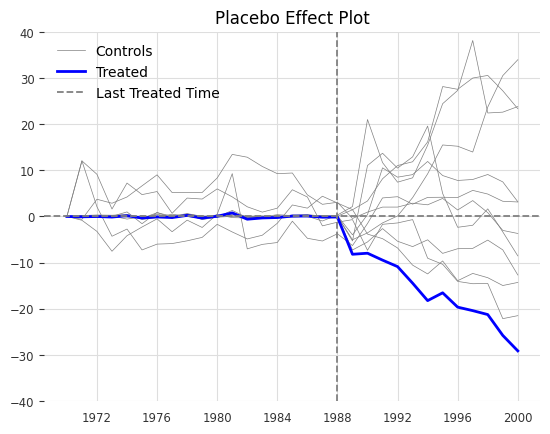

0.02911959810113296

In [5]:
placebo_predictions, p_value = model.placebo_test(control_ids=[i for i in range(4,14)], use_gpu=1)
p_value

## Multiple Treated Units

There may be situations that mure than one unit are treated. Say not only State `3` (California), but also State `4` and `5` are treated. You can use our model in the following two ways

### Fit one model on all treated units

In [6]:
from SyNBEATS import * 
import pandas as pd
from tqdm.auto import tqdm

dta = pd.read_csv("smoking_data.csv")
dta = dta[["state", "year", "cigsale"]]
dta.columns = ["id", "time", "Y_obs"]

model = SyNBEATS(dta, [3, 4, 5], 1989)

In [7]:
model.train(use_gpu=False)
predictions = model.predictions()
model.plot_predictions(predictions)
model.plot_gap()


  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.278    Total estimated model params size (MB)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

ValueError: Could not find a unique inferred frequency (not constant). Observed frequencies: {0, 1}. If any of those is the actual frequency, try passing it with `fill_missing_dates=True` and `freq=your_frequency`.


ValueError: Could not find a unique inferred frequency (not constant). Observed frequencies: {0, 1}. If any of those is the actual frequency, try passing it with `fill_missing_dates=True` and `freq=your_frequency`.

<Figure size 640x480 with 0 Axes>

In [ ]:
ate = model.average_treatment_effect()
std = model.std_treatment_effect()
ate, std

For placebo testing with multiple treated units, the control combinations have to have the same number of units as the treated units, which makes computation much more intensive. Thus we do not recommend or support this feature. The following function call will raise an error: `Placebo test for multiple treated units is not supported, please see documentation for more information`

In [ ]:
model.placebo_test(control_ids=[i for i in range(4,7)], use_gpu=False)

### Fit one model for each treated unit

When there are not too many units, you can also create a model for each of the treated unit and fit them seperately. Keep in mind that the control units for each treated units should be the units that are never treated. For example, you can use the following command to get the control units:
```python
control_ids = list(set(dta['id']) - set(treat_ids))
```

In [11]:
from SyNBEATS import * 
import pandas as pd
from tqdm.auto import tqdm

dta = pd.read_csv("smoking_data.csv")
dta = dta[["state", "year", "cigsale"]]
dta.columns = ["id", "time", "Y_obs"]

treat_ids = [3, 4, 5]
control_ids = list(set(dta['id']) - set(treat_ids)) # the control units for each treated unit should not be treated at all 

models = [SyNBEATS(dta, [treat_id], 1989, control_ids=control_ids) for treat_id in treat_ids] # create a model for each treated unit


  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.214    Total estimated model params size (MB)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


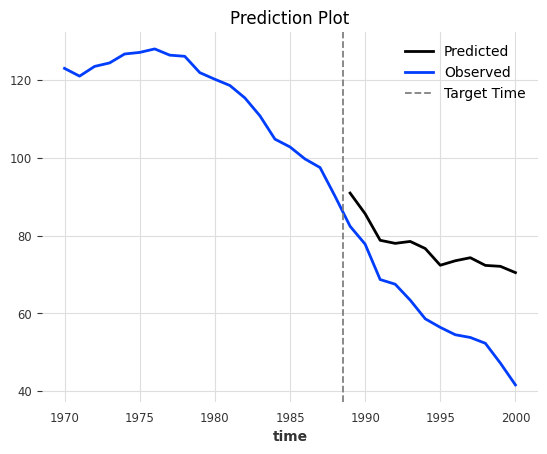

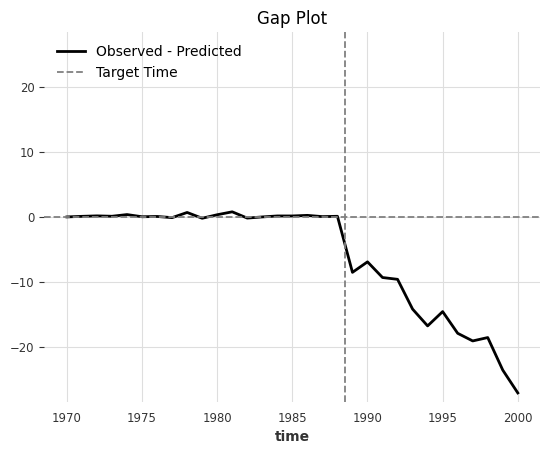

Starting the placebo test...


Processing placebo for control id 9: 100%|██████████| 3/3 [09:28<00:00, 189.55s/it]


Placebo test completed.


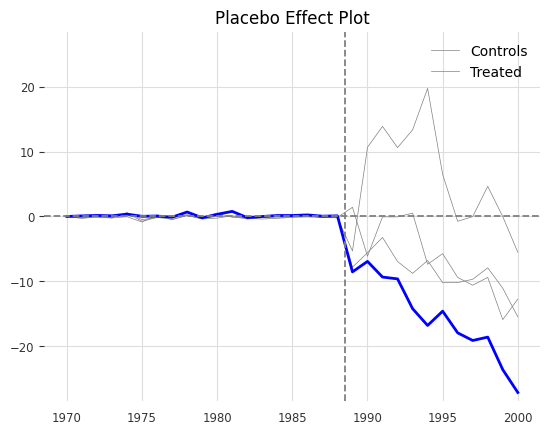


  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.214    Total estimated model params size (MB)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


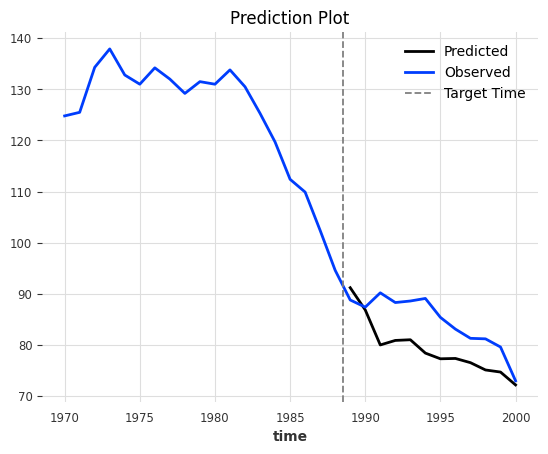

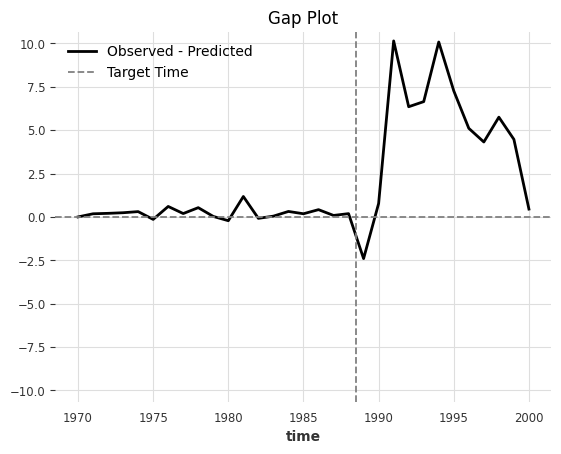

Starting the placebo test...


Processing placebo for control id 8:  33%|███▎      | 1/3 [01:39<03:18, 99.08s/it]

KeyboardInterrupt



In [12]:
for model in models:
    model.train(use_gpu=False)
    predictions = model.predictions()
    model.plot_predictions(predictions)
    model.plot_gap()
    
    ate = model.average_treatment_effect()
    std = model.std_treatment_effect()
    ate, std
    
    model.placebo_test(control_ids=[i for i in range(7, 10)], use_gpu=False)